# Potential Field Extrapolator Prototype
Prototype for a basic potential field extrapolator

In [1]:
import os

import numpy as np
import numba
import matplotlib.pyplot as plt
import sunpy.map
import astropy.units as u
import solarbextrapolation.example_data_generator
import solarbextrapolation.extrapolators

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Synthetic Magnetogram
First, create the fake magnetogram

In [2]:
arr_grid_shape = [ 300, 300]
xrange = u.Quantity([ -150.0, 150.0 ] * u.arcsec)
yrange = u.Quantity([ -150.0, 150.0 ] * u.arcsec)

In [3]:
num_spots = 1
fraction = 1./num_spots
strength = 5e3
spread = 5
spots = []
for i in range(num_spots):
    rand_y_pos = 35 #+ 30*np.random.rand()
    rand_x_pos = 35 #+ 30*np.random.rand()
    spots.append(( u.Quantity([ rand_x_pos, rand_y_pos ] * u.percent), 
                   spread * u.percent,  fraction*strength * u.Gauss ))
    rand_y_neg = 65 #- 30*np.random.rand()
    rand_x_neg = 65 #- 30*np.random.rand()
    spots.append(( u.Quantity([ rand_x_neg, rand_y_neg ] * u.percent),
                   spread * u.percent,  -fraction*strength * u.Gauss ))

In [4]:
delta_x = xrange[1] - xrange[0]
delta_y = yrange[1] - yrange[0]
dx = delta_x/arr_grid_shape[0]
dy = delta_y/arr_grid_shape[1]
synthetic_hmi_data = np.zeros(arr_grid_shape)
xphysical,yphysical = np.meshgrid(np.arange(arr_grid_shape[0])*dx,np.arange(arr_grid_shape[1])*dy)
for spot in spots:
    if spot[0].unit is u.percent:
        pos = u.Quantity([spot[0][0].value/100.*delta_x + xrange[0],
                          spot[0][1].value/100.*delta_y + yrange[0]])
    else:
        pos = spot[0]
    if spot[1].unit is u.percent:
        sigma = spot[1].value/100.*delta_x
    else:
        sigma = spot[1]
    An_max   = spot[2].value
    An_x     = pos[0]
    An_y     = pos[1]
    An_Dx    = xphysical - An_x + xrange[0]
    An_Dy    = yphysical - An_y + yrange[0]
    An_DxSqu = An_Dx.value**2.0
    An_DySqu = An_Dy.value**2.0
    An_Sigma = sigma.value

    # So this contibution is calculated and added.
    synthetic_hmi_data += An_max * np.exp( - ( (An_DxSqu + An_DySqu) / (2 * An_Sigma**2.0)) )

In [5]:
synthetic_hmi_map = solarbextrapolation.example_data_generator.dummyDataToMap(synthetic_hmi_data,xrange,yrange)
tmp = sunpy.map.Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits')
for key in ['ctype1','ctype2','rsun_ref','rsun_obs','dsun_ref','dsun_obs','wcsname','crlt_obs','t_obs','date-obs']:
    synthetic_hmi_map.meta[key] = tmp.meta[key]

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


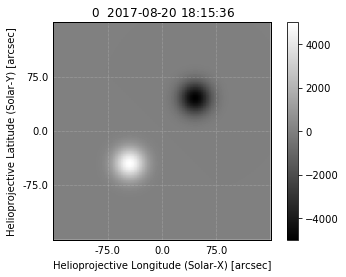

In [6]:
synthetic_hmi_map.peek()

## Extrapolate Field--Existing Library

In [7]:
def angle_to_length(m, arc, **kwargs):
    length = (m.dsun - m.rsun_meters) * arc.to(u.radian)
    return length.to(u.m, equivalencies=u.dimensionless_angles())

In [8]:
zrange = u.Quantity([0,100],u.arcsec)
zshape = 100

In [17]:
angle_to_length(resampled_map,zrange)

<Quantity [        0.        , 73021545.21541907] m>

In [9]:
resampled_map = synthetic_hmi_map.resample(u.Quantity([100,100],u.pixel))

In [21]:
extrapolator = solarbextrapolation.extrapolators.PotentialExtrapolator(resampled_map,
                                                                       zshape=zshape,
                                                                       zrange=zrange)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev150-py3.5.egg/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev150-py3.5.egg/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev150-py3.5.egg/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/

In [22]:
map3d = extrapolator.extrapolate(enable_numba=True)

True


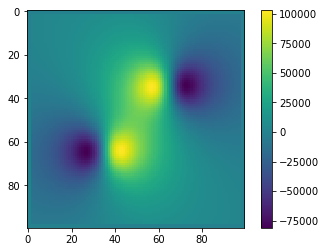

In [23]:
plt.imshow(np.flipud(map3d.data[:,:,:,1].sum(axis=2)))
plt.colorbar()

In [ ]:
for k in map3d.meta.keys():
    if k != 'boundary_1_meta':
        print('{} : {}'.format(k,map3d.meta[k]))

### Inspection

In [ ]:
extrapolator.Dx.to(resampled_map.meta['cunit1'])

In [ ]:
extrapolator.xrange.to(resampled_map.meta['cunit1'])

In [ ]:
extrapolator.yrange

In [ ]:
extrapolator.zrange

In [ ]:
extrapolator.map_boundary_data.meta

In [ ]:
map3d.meta

## Extrapolate Field--Custom Implementation

In [ ]:
@numba.jit(nopython=True)
def greens_function(x,y,z,x_point,y_point,z_point):
    d_x = x - x_point
    d_y = y - y_point
    d_z = z - z_point
    dist = np.sqrt(d_x**2 + d_y**2 + d_z**2)
    return 1./(2.*np.pi*dist)


@numba.jit(nopython=True)
def phi_potential(boundary, shape, x_grid, y_grid, dx, dy, dz):
    z_under = dz/np.sqrt(2.*np.pi)
    extrapolated_volume = np.empty((shape[1],shape[0],shape[2]))
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                x = i*dx
                y = j*dy
                z = k*dz
                green = greens_function(x,y,z,x_grid,y_grid,z_under)
                extrapolated_volume[j,i,k] = np.sum(boundary*green*dx*dy)
                
    return extrapolated_volume


def vector_field(phi):
    b_field = np.zeros(phi.shape+(3,))
    b_field[2:-2,2:-2,2:-2,0] = -(phi[:-4,2:-2,2:-2] 
                                  - 8.*phi[1:-3,2:-2,2:-2] 
                                  + 8.*phi[3:-1,2:-2,2:-2]
                                  - phi[4:,2:-2,2:-2])/12.
    b_field[2:-2,2:-2,2:-2,1] = -(phi[2:-2,2:-2,:-4] 
                                  - 8.*phi[2:-2,1:-3,2:-2] 
                                  + 8.*phi[2:-2,3:-1,2:-2]
                                  - phi[2:-2,2:-2,4:])/12.
    b_field[2:-2,2:-2,2:-2,2] = -(phi[2:-2,2:-2,:-4] 
                                  - 8.*phi[2:-2,2:-2,1:-3] 
                                  + 8.*phi[2:-2,2:-2,3:-1]
                                  - phi[2:-2,2:-2,4:])/12.
    
    
    return b_field

def extrapolate(magnetogram, zshape, zrange):
    shape = (magnetogram.data.shape[1],magnetogram.data.shape[0],zshape)
    dx = angle_to_length(magnetogram,magnetogram.xrange[1]) - angle_to_length(magnetogram,magnetogram.xrange[0])
    dx /= magnetogram.data.shape[1]
    dy = angle_to_length(magnetogram,magnetogram.yrange[1]) - angle_to_length(magnetogram,magnetogram.yrange[0])
    dy /= magnetogram.data.shape[0] 
    dz = np.diff(zrange)[0]/zshape
    
    y_index,x_index = np.indices(shape[:2])
    x_grid = dx*x_index
    y_grid = dy*y_index
    phi = phi_potential(magnetogram.data, shape, x_grid, y_grid, dx.value, dy.value, dz.value)
    
    b_field = vector_field(phi)
    
    return b_field

In [ ]:
b_field = extrapolate(resampled_map, zshape, zrange)

In [ ]:
plt.imshow(b_field[:,:,:,2].sum(axis=2))
plt.colorbar()